Pré-Tratamento de Gás Natural
---

This file investigate the PreTratamento subsob from the UGH with a final goal of creating a MPPCA model that correctly represents the normal condition of operation of the subsob.

In [1]:

# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import numpy.ma as ma
from StringIO import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap 
from scipy import linalg
from scipy.stats import randint
from operator import itemgetter

from time import time

from sklearn.mixture import MPPCA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_blobs

In [2]:
# TODO deal with time 
# TODO deal with the names (elimated to generate a 2D array)
# The data should be on subdirectory called "data"
old_selected_data = np.genfromtxt("./data/old_orig_data.csv",
              dtype=float,
              skip_header=1,
              autostrip=True,
              delimiter=",",
              usecols=(13, 14, 15, 33, 43, 30, 44),
              usemask=True,
              missing_values="NA")
print 'Loaded {} samples from {} variables.'.format(old_selected_data.shape[0], old_selected_data.shape[1])

Loaded 57008 samples from 7 variables.


In [3]:
# Deal with Nans
# In here, as we will consider delayed samples, where the Nans happen is important
# For now, we assume we have few nans, and the impact on this wrong delayed sampling in minor and just ignore
# Get only Complete rows
old_data = ma.compress_rows(old_selected_data)
print 'Got {} clean samples from {} variables'.format(old_data.shape[0], old_data.shape[1])

# Normalize Data
old_mean = np.mean(old_data, axis=0)
old_std = np.std(old_data, axis=0)
old_norm_data = np.subtract(old_data, old_mean)
old_norm_data = np.divide(old_norm_data, old_std)

# Get desired delays
delays = [5, 10]
old_final_data = old_norm_data
for delay in delays:
    b = np.roll(old_norm_data, delay, axis=0)
    old_final_data = np.hstack((old_final_data, b))
old_final_data = old_final_data[np.max(delays):, :]
print 'Got final {} samples from {} variables.'.format(old_final_data.shape[0], old_final_data.shape[1])

Got 56333 clean samples from 7 variables
Got final 56323 samples from 21 variables.


In [5]:
# Divide data between training and testing sets
train_idx_lim = 32393
X_train = old_final_data[1:train_idx_lim, :]
t_train = np.arange(train_idx_lim-1)
X_val = old_final_data[(train_idx_lim+1):, :]
t_val = np.arange(train_idx_lim+1, old_final_data.shape[0])
print 'Divided data in {} training samples and {} testing samples.'.format(X_train.shape[0], X_val.shape[0])

Divided data in 32392 training samples and 23929 testing samples.


In [6]:
# Execute RandomSearch
# This aims to create a early model just to try and eliminate outliers in the traning data
# Set the parameters by cross-validation
# run randomized search
n_features = old_final_data.shape[1]
min_comp = 1
max_comp = 8
n_iter_search = 10
# Specify parameters and distributions to sample from
param_dist = {'n_components': randint(min_comp, max_comp),
              'n_pc' : randint(1, n_features),
              'verbose': [0]}

# Run random search
random_search = RandomizedSearchCV(MPPCA(),
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring=MPPCA.sum_score,
                                   cv=5,
                                   verbose=1)
random_start = time()
random_search.fit(X_train)
random_end = time()
print("RandomSearchCV took %.2f seconds for %d candidate parameter settings."
      % (random_end - random_start, len(random_search.grid_scores_)))

# Get the best model
random_best = random_search.best_estimator_
print 'The best found model was: '
print random_best

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   45.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   45.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomSearchCV took 47.41 seconds for 10 candidate parameter settings.
The best found model was: 
MPPCA(init_params='wmpn', min_covar=0.001, n_components=5, n_init=1,
   n_iter=100, n_pc=17, params='wmpn', random_state=None, tol=0.001,
   verbose=0)


In [9]:
# Compute the desired threshold to eliminate outliers
perct_to_eliminate = 0.05
random_logprob_train, random_responsability_train = random_best.score_samples(X_train)
sorted_random_logprob_sample = np.sort(random_logprob_train)
threshold_outlier = sorted_random_logprob_sample[int(np.round(len(sorted_random_logprob_sample)*perct_to_eliminate))]
selected_train_idxs = sorted_random_logprob_sample > threshold_outlier
print '{} outliers were removed, resulting in {} samples for the training set.'.format(len(sorted_random_logprob_sample) - np.sum(selected_train_idxs), len(sorted_random_logprob_sample))

1621 outliers were removed, resulting in 32392 samples for the training set.


In [10]:
# Execute GridSearch
# This finds the best model for the selected data
# Set the parameters by cross-validation
param_grid = [{'n_components': np.arange(min_comp, max_comp + 1),
                     'n_pc' : np.arange(n_features - 1) + 1,
                     'verbose' : [0]}]

# Run grid search
grid_search = GridSearchCV(MPPCA(),
                           param_grid=param_grid,
                           scoring=MPPCA.sum_score,
                           cv=5,
                           verbose=2)
grid_start = time()
grid_search.fit(X_train[selected_train_idxs, :])
grid_end = time()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (grid_end - grid_start, len(grid_search.grid_scores_)))

grid_best = grid_search.best_estimator_
print 'The best found model was: '
print grid_best

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   0.2s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   0.2s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   0.2s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   0.2s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   0.2s
[CV] n_pc=2, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=2, n_components=1, verbose=0 -   0.2s
[CV] n_pc=2, n_components=1, verbose=0 ...............................
[CV] .........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:   52.1s



[CV] n_pc=13, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=13, n_components=2, verbose=0 -   0.5s
[CV] n_pc=13, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=13, n_components=2, verbose=0 -   0.6s
[CV] n_pc=13, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=13, n_components=2, verbose=0 -   0.5s
[CV] n_pc=13, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=13, n_components=2, verbose=0 -   0.5s
[CV] n_pc=14, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=14, n_components=2, verbose=0 -   0.6s
[CV] n_pc=14, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=14, n_components=2, verbose=0 -   0.5s
[CV] n_pc=14, n_components=2, verbose=0 ..............................
[CV] ..................... n_pc=14, n_components=2, verbose=0 -   0.7s
[CV] 

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed: 11.6min



[CV] n_pc=10, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=10, n_components=7, verbose=0 -   2.0s
[CV] n_pc=10, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=10, n_components=7, verbose=0 -   1.6s
[CV] n_pc=10, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=10, n_components=7, verbose=0 -   3.0s
[CV] n_pc=11, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=11, n_components=7, verbose=0 -   2.2s
[CV] n_pc=11, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=11, n_components=7, verbose=0 -   2.3s
[CV] n_pc=11, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=11, n_components=7, verbose=0 -   2.0s
[CV] n_pc=11, n_components=7, verbose=0 ..............................
[CV] ..................... n_pc=11, n_components=7, verbose=0 -   2.0s
[CV] 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 18.0min finished


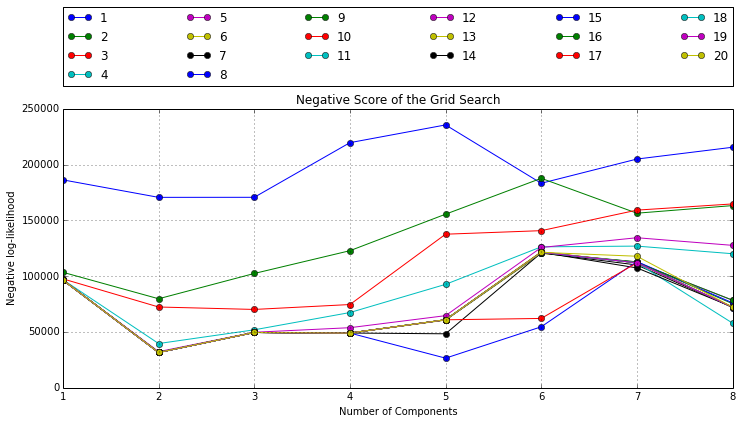

In [11]:
# Score analysis for the trained models        
grid_scores = grid_search.grid_scores_
# Analyse models based on the validation data set
num_comps = np.arange(min_comp, max_comp + 1)
n_pcs = np.arange(n_features - 1) + 1
grid_search_neg_sum_loglike = np.zeros((len(num_comps), len(n_pcs)))

for score in grid_scores:
    n_pc_idx = score.parameters.get('n_pc') - 1
    n_comp_idx = score.parameters.get('n_components') - 1
    grid_search_neg_sum_loglike[n_comp_idx, n_pc_idx] = -score.mean_validation_score
        
plt.figure(figsize=(12, 5))
plt.plot(num_comps, grid_search_neg_sum_loglike, marker='o')
plt.legend(n_pcs, bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0.)
plt.title('Negative Score of the Grid Search')
plt.ylabel('Negative log-likelihood')
plt.xlabel('Number of Components')
plt.grid()
plt.show()

The threshold via Monte Carlo is -4.98460437378


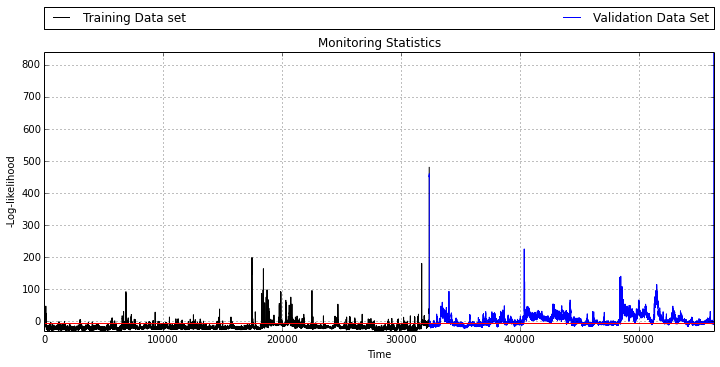

2124 samples from training data is out of control. That represents 6.55717461102 of the data.
15421 samples from validation data is out of control. That represents 64.4448159137 of the data.


In [12]:
best_model = grid_best
# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = best_model.sample(N_sample)
logprob_sample, responsability_sample = best_model.score_samples(best_model_sample)
sorted_logprob_sample = np.sort(logprob_sample)
threshold = sorted_logprob_sample[int(np.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = best_model.score_samples(X_train)
logprob_val, responsability_val = best_model.score_samples(X_val)

plt.figure(figsize=(12, 5))
plt.plot(t_train, -logprob_train, color = 'black')
plt.plot(t_val, -logprob_val, color = 'blue')
plt.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
plt.axis('tight')
plt.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Monitoring Statistics')
plt.ylabel('-Log-likelihood')
plt.xlabel('Time')
plt.grid()
plt.show()
out_train = np.sum(-logprob_train > -threshold)
print '{} samples from training data is out of control. That represents {} of the data.'.format(out_train, float(out_train)/float(len(logprob_train))*100)
out_val = np.sum(-logprob_val > -threshold)
print '{} samples from validation data is out of control. That represents {} of the data.'.format(out_val, float(out_val)/float(len(logprob_val))*100)

Loaded 66236 samples from 7 variables.
Got 66229 clean samples from 7 variables
Got final 66219 samples from 21 variables.


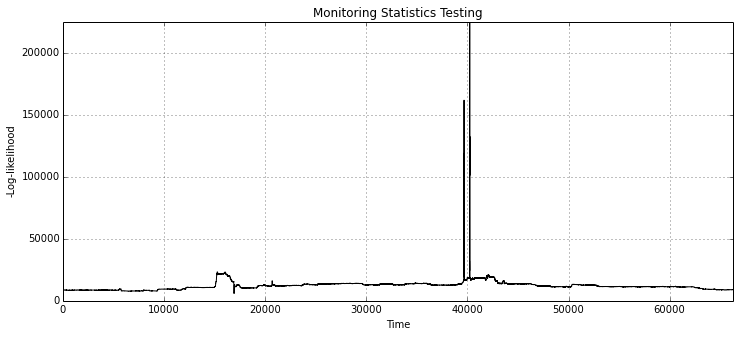

66219 samples from testing data is out of control. That represents 100.0 of the data.


In [13]:
# TODO deal with time 
# TODO deal with the names (elimated to generate a 2D array)
# The data should be on subdirectory called "data"
new_selected_data = np.genfromtxt("./data/new_orig_data.csv",
              dtype=float,
              skip_header=1,
              autostrip=True,
              delimiter=",",
              usecols=(13, 14, 15, 33, 43, 30, 44),
              usemask=True,
              missing_values="NA")
print 'Loaded {} samples from {} variables.'.format(new_selected_data.shape[0], new_selected_data.shape[1])

# Deal with Nans
# In here, as we will consider delayed samples, where the Nans happen is important
# For now, we assume we have few nans, and the impact on this wrong delayed sampling in minor and just ignore
# Get only Complete rows
new_data = ma.compress_rows(new_selected_data)
print 'Got {} clean samples from {} variables'.format(new_data.shape[0], new_data.shape[1])

# Normalize Data
new_norm_data = np.subtract(new_data, old_mean)
new_norm_data = np.divide(new_norm_data, old_std)

# Get desired delays
new_final_data = new_norm_data
for delay in delays:
    b = np.roll(new_norm_data, delay, axis=0)
    new_final_data = np.hstack((new_final_data, b))
new_final_data = new_final_data[np.max(delays):, :]
print 'Got final {} samples from {} variables.'.format(new_final_data.shape[0], new_final_data.shape[1])

new_logprob_train, new_responsability_train = best_model.score_samples(new_final_data)

plt.figure(figsize=(12, 5))
plt.plot(-new_logprob_train, color = 'black')
plt.plot((1, len(new_logprob_train)), (-threshold, -threshold), color = 'red')
plt.axis('tight')
plt.title('Monitoring Statistics Testing')
plt.ylabel('-Log-likelihood')
plt.xlabel('Time')
plt.grid()
plt.show()
new_out_train = np.sum(-new_logprob_train > -threshold)
print '{} samples from testing data is out of control. That represents {} of the data.'.format(new_out_train, float(new_out_train)/float(len(new_logprob_train))*100)

In [14]:
new_mean = np.mean(new_norm_data, axis=0)
new_std = np.std(new_norm_data, axis=0)

print new_mean
print new_std

[-8.377951407866702 -10.702214309604626 -1.1087811077722967
 -1.848453993829402 -4.6637688671653565 -0.8601868006671186
 -5.887440563095094]
[5.737632591262809e-13 0.012141120853150727 1.1070717506918126
 1.0675761522758473 0.8741678114966263 1.0386876132190597
 1.5324129164276268]


In [15]:
print np.mean(new_data, axis=0)

[  1.00009200e+00   4.43943487e+01   3.05475048e+03   1.63610362e+01
   3.38842198e+02   3.43412766e-01   3.16457281e+02]
